In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils.filepaths.filepaths import (
    FILE_PATH_CASE_102,
    FILE_PATH_CASE_102_HFM_T,
    FILE_PATH_CASE_102_HFM_T_OBS,
    FILE_PATH_CASE_102_HFM_Z,
    FILE_PATH_TEST_SET_CASE_102,
    RHEOLOGY_DATA_CASE_102_PATH
)

from utils.utils.utils import (
    get_active_drilling_data,
    reading_labeled_drill_report_data,
    extracting_labeled_data_from_dataframe,
    plot_sections,
    map_pars_t_z,
    extract_time_series_from_depth_data_for_given_variables,
    get_herschel_bulkley_parameters_from_rheology_file,
    get_testing_dataset_from_field_data
)

sns.set_theme()

In [34]:
# Loading files
sensor_data_case_102 = pd.read_pickle(FILE_PATH_CASE_102)
# Extracting the dates to consider
tstamp_min = '2020-08-17 12:00:00+00:00'
tstamp_max = '2020-08-21 13:00:00+00:00'
sensor_data_case_102 = sensor_data_case_102.loc[tstamp_min:tstamp_max]
# First datapoint was removed during pickling of simdata. Have to so the same here
sensor_data_case_102 = sensor_data_case_102.iloc[1:] 
hfm_data_case_102_t = pd.read_pickle(FILE_PATH_CASE_102_HFM_T)
hfm_data_case_102_t_obs = pd.read_pickle(FILE_PATH_CASE_102_HFM_T_OBS)
hfm_data_case_102_z = pd.read_pickle(FILE_PATH_CASE_102_HFM_Z)


In [35]:
# Getting the indices for the model data right
start_date = '2020-08-17 12:00:10+00:00'
date_range = pd.date_range(start = start_date, periods = len(hfm_data_case_102_t), freq='10s')
hfm_data_case_102_t.index = date_range
# hfm_data_case_102_t_obs.index = date_range
hfm_data_case_102_t.head()
hfm_data_case_102_t.columns

Index(['Rate_in', 'SPP', 'ECD_bot', 'ECD_shoe', 'P_choke', 'FrontFluid2',
       'FrontFluid3', 'FrontFluid4', 'FrontFluid5', 'FrontFluid6', 'totVolInj',
       'totStrokes', 'totVolOut', 'pitVol', 'WHP', 'volRateOut', 'dsGap',
       'BHP', 'T_bot', 'T_top', 'mdBit', 'ecdAtPos', 'pAtPos', 'TAtPos',
       'dsRpm', 'rop', 'xFactor', 'kFactor', 'yCalc', 'yCalcAvg', 'yMeas',
       'Pxy', 'Pyy', 'Pa', 'Gel1', 'Gel2', 'Gel3', 'Gel4', 'Gel5', 'ShieldBHA',
       'ShieldAnn', 'ShieldRiser', 'CtrBHA', 'CtrAnn', 'CtrRiser',
       'CutConsBHA', 'CutConsAnn', 'CutConsRiser', 'ReynBHA', 'ReynAnn',
       'ReynRiser', 'TaylBHA', 'TaylAnn', 'TaylRiser', 'RouseBHA', 'RouseAnn',
       'RouseRiser', 'voidShoe', 'voidAtBha', 'cutSt', 'vDev', 'pDev',
       'mTotMud', 'mFreeGas', 'mDGas', 'qLoss', 'mLost', 'XFactor',
       'DSXFactor'],
      dtype='object')

In [36]:
print(len(sensor_data_case_102), len(hfm_data_case_102_t))
sensor_data_case_102.head()

34920 34920


,WOB,HKLD,MUD_FLOW_OUT,BLOCKPOS,ROP,TORQ,MUD_FLOW_IN,MUD_DENS_OUT,PUMP_PRESS,PIT_TOT,...,D1AX-Relog,D1AY-Relog,PWPI-Relog,EAAF-Relog,DGRCC-Relog,PW16-Relog,D1SS-Relog,ALCDH-Relog,RDGDTVSS-Relog,D1AZ-Relog
TIME,,,,,,,,,,,,,,,,,,,,,
2020-08-17 12:00:10+00:00,0.0,1237026.975,0.0,3.207609,0.0,43.313541,0.008581,1045.691609,342979.631424,133.345871,...,1.2,1.2,123.655479,-0.014492,20.292362,1918.0,175.0,0.0,175.0,15.2
2020-08-17 12:00:20+00:00,0.0,1240142.925,0.0,3.207609,0.0,43.116738,0.010817,1045.691609,349296.565056,133.345871,...,1.2,1.2,123.785362,-0.014492,20.292362,1919.0,175.0,0.0,175.0,15.2
2020-08-17 12:00:30+00:00,0.0,1241293.025,0.0,3.207609,0.0,38.609064,0.014965,1045.691609,342705.998421,132.986267,...,1.2,1.2,123.785362,-0.014492,20.292362,1918.0,175.0,0.0,175.0,15.2
2020-08-17 12:00:40+00:00,0.0,1241599.800,0.0,3.207609,0.0,36.032622,0.016277,1045.691609,336912.765503,132.986267,...,1.2,1.2,123.785362,-0.014492,18.037655,1918.0,175.0,0.0,175.0,15.2
2020-08-17 12:00:50+00:00,0.0,1242255.525,0.0,3.207609,0.0,34.432376,0.016945,1045.691609,334300.069809,132.986267,...,1.2,1.2,123.785362,-0.014492,18.037655,1918.0,175.0,0.0,175.0,15.2


In [37]:

# sensor_data_case_102, hfm_data_case_102_t = get_active_drilling_data(sensor_data_case_102, hfm_data_case_102_t, include_rop_zeros=True)
# Wait to get obs data. Not sure if it is necassary
# hfm_data_case_102_t_obs = hfm_data_case_102_t_obs.loc[hfm_data_case_102_t.index]

In [38]:
print(len(sensor_data_case_102), len(hfm_data_case_102_t),len(hfm_data_case_102_t_obs))
hfm_data_case_102_t.index = sensor_data_case_102.index
hfm_data_case_102_t_obs.index = sensor_data_case_102.index

34920 34920 34920


In [39]:
min_depth = 0 
max_depth = 5820

depth_data =  hfm_data_case_102_z[0]
depth_data_columns = hfm_data_case_102_z[1]

In [40]:
depth_data.shape


(18, 34920, 511)

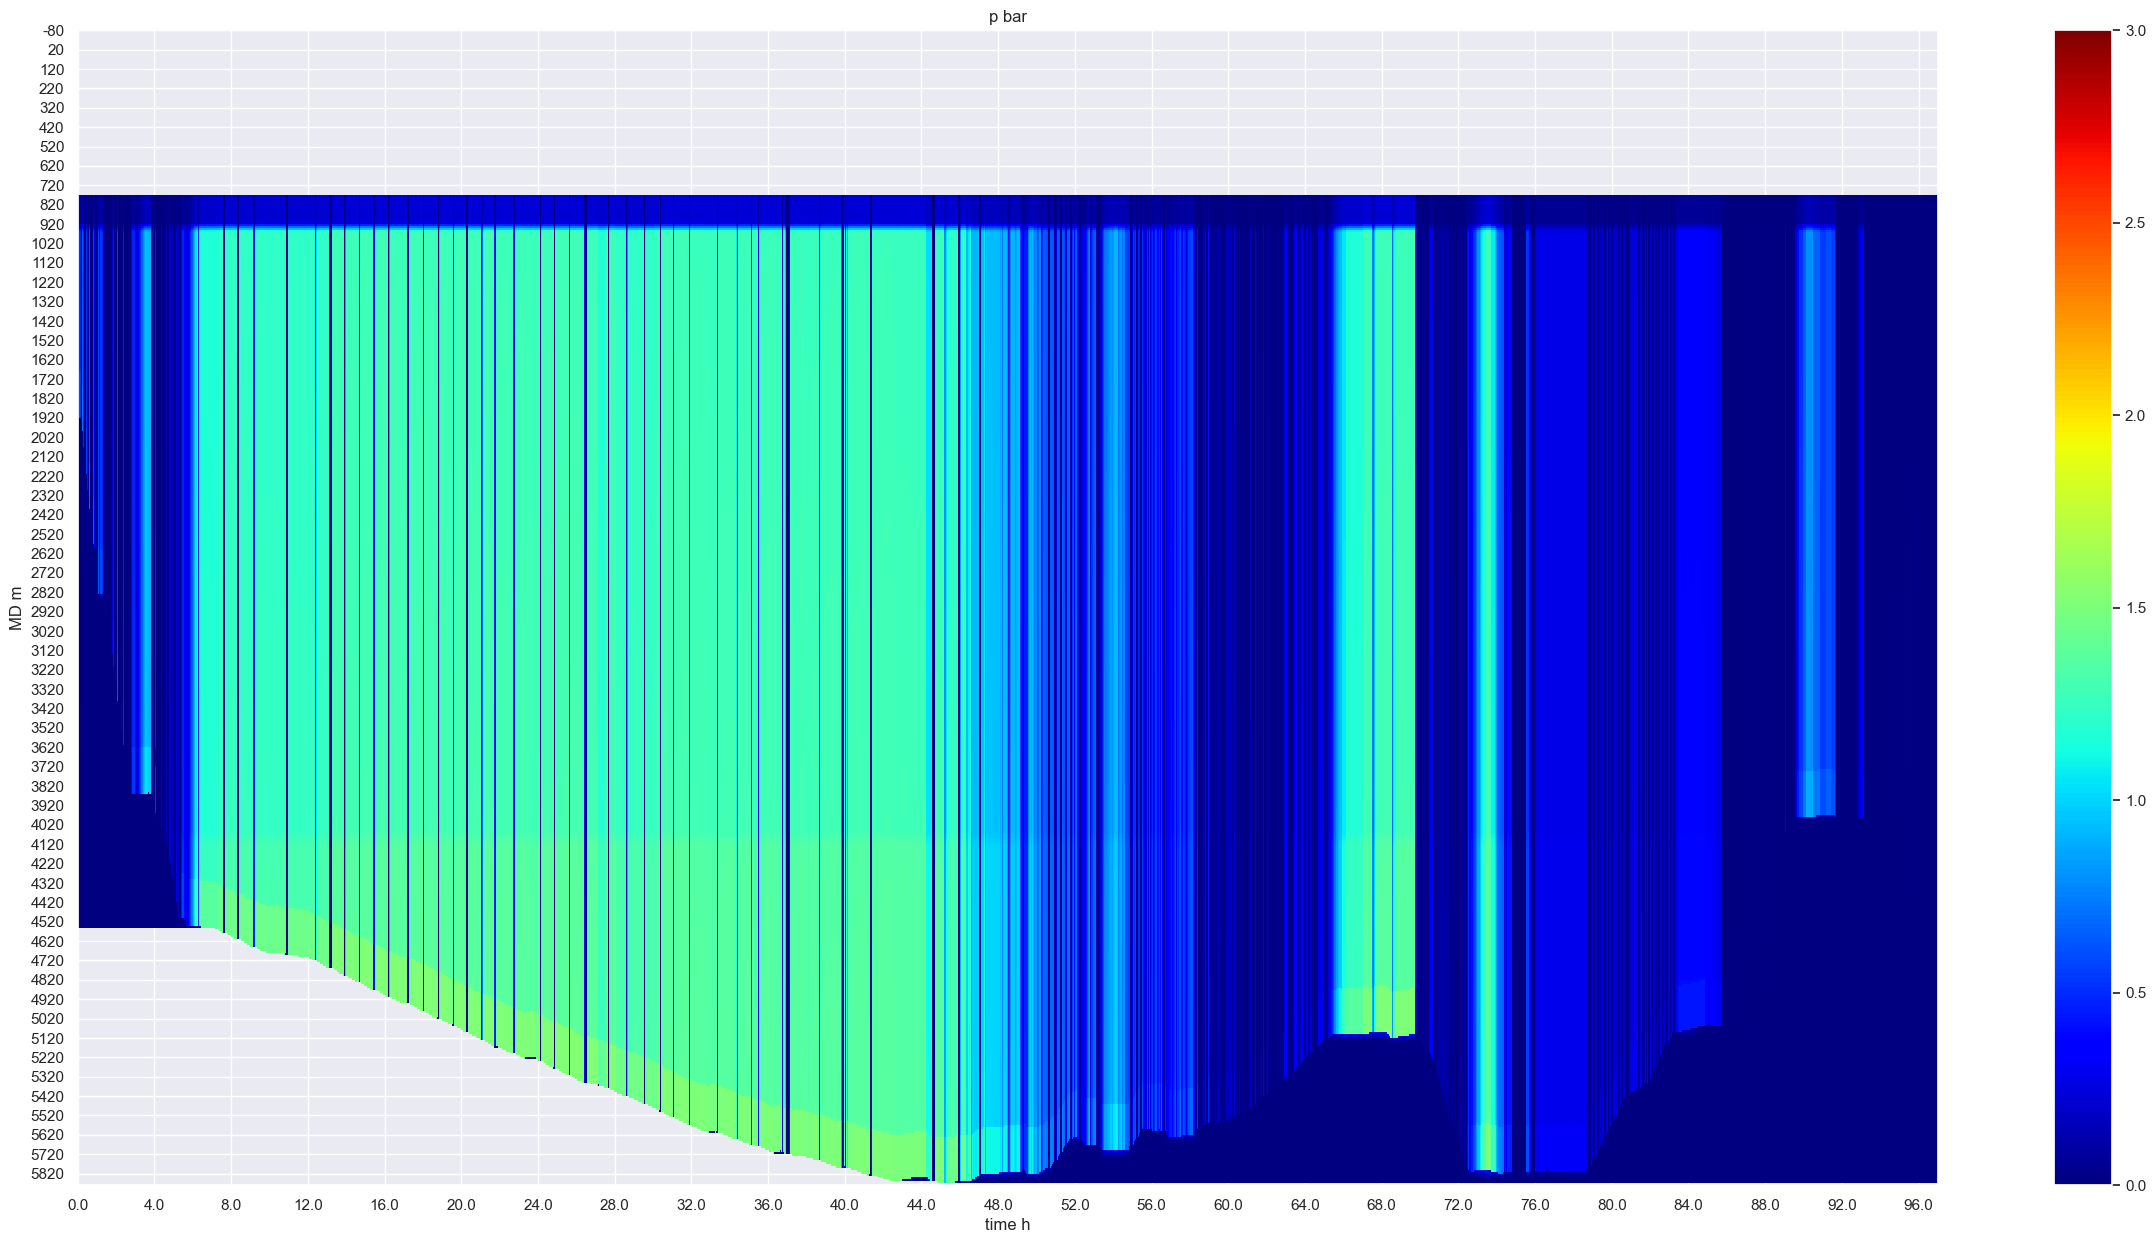

In [58]:
fig,ax = plt.subplots(figsize=(30,15))
obj =ax.pcolormesh(depth_data[-2,:,::-1].T,cmap='jet',vmin=0,vmax=3)
ax.set_yticks(np.arange(6,600,10))
ax.set_yticklabels(np.arange(max_depth,-100,-100))
ax.set_ylabel('MD m')
ax.set_xticks(np.arange(0,34920,1440))
ax.set_xticklabels(np.arange(0,34920/360,4))
ax.set_xlabel('time h')
ax.set_title('p bar')
plt.colorbar(obj,ax=ax)

In [42]:
asm_sensor_2 = sensor_data_case_102["ASMDEP2-T"]


In [43]:
values_for_position = extract_time_series_from_depth_data_for_given_variables(depth_data=depth_data, position_for_time_series=asm_sensor_2.values,columns=depth_data_columns)

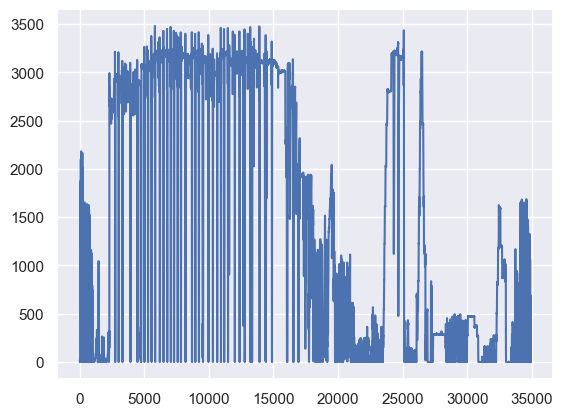

In [44]:
plt.plot(values_for_position["reyn"])
plt.show()

In [45]:

# m / s^2
gravitational_constant = 9.80
# m
DH = 0.06985
# m
charecteristic_length = 0
liquid_velocities = values_for_position["vL"]
pressure_gradient = values_for_position["dpf"]
# Unsure if this densisty value is the correct one
fluid_density = values_for_position["avgDensity"]
pressure = values_for_position["pOut/pBar"]
# Value blows up when there is little flow. Don't think this will be a problem during steady state conditions
fanning = DH * pressure_gradient / (2 * fluid_density * liquid_velocities**2)
values_for_position["Friction factor"] = fanning


In [46]:
inclination = np.arccos(hfm_data_case_102_t_obs["TvdAtPpos1"].diff() /  hfm_data_case_102_t["mdBit"].diff()) * 180 / np.pi

c:\Users\thomaswi\AppData\Local\miniconda3\envs\master_thesis\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


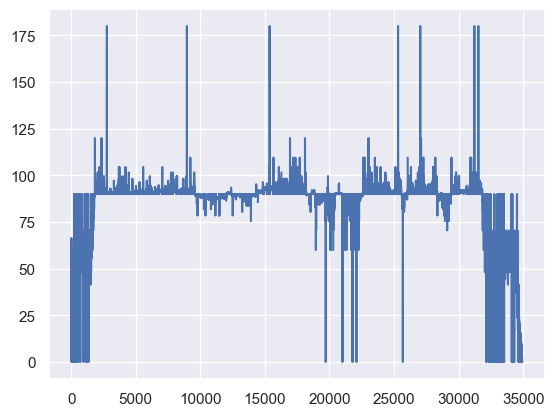

In [47]:
# Visual inspection provides us with the knowledge that the inclination is 
# 90 degrees during the entire drilling operation

plt.plot(inclination.values)


In [48]:
indices_case_102 =[4100,4600,4900,11600,13100] 
# These are the transients
indices_case_102 = [535,735,1275,1780,3610,4935,4975,5203,5370,6923,7265,7640,7880,8295,9330,10045,10560,11225,12850]

In [49]:
values_for_position_df = pd.DataFrame(values_for_position)
values_for_position_df.index = sensor_data_case_102.index
drilling_sensor_data_case_102, values_for_position_df = get_active_drilling_data(sensor_data_case_102, sim_df=values_for_position_df ,include_rop_zeros=True)

In [50]:
print(len(drilling_sensor_data_case_102))

13717


In [51]:
hb_parameters = get_herschel_bulkley_parameters_from_rheology_file(RHEOLOGY_DATA_CASE_102_PATH) 
hb_parameters.head(11)    

,Temperature,Pressure,Consistency index (K),Yield stress (tau_y),Flow behaviour index (n)
0,50.0,1.0,0.902249,0.064411,0.796957
1,50.0,103.0,1.145990,0.038647,0.887717
2,70.0,138.0,1.363140,0.054337,0.819334
3,70.0,172.0,1.357320,0.056890,0.820349
4,100.0,207.0,1.656580,0.072227,0.772995
5,100.0,241.0,1.593770,0.057289,0.814421
6,120.0,276.0,1.530710,0.071310,0.768217
7,120.0,310.0,1.500920,0.050376,0.821522
8,120.0,345.0,1.350200,0.051985,0.806962
9,120.0,414.0,1.348380,0.047958,0.827776


In [52]:
values_for_position_df.head()
yield_stress = []
consistency_index = []
flow_behaviour_index = []
temperature_regions = values_for_position_df["TOut"].apply(lambda x: 1 if x > 85 else 0)
hb_parameters_for_case = np.array([hb_parameters.loc[5] if t_region == 1 else hb_parameters.loc[3] for t_region in temperature_regions])

print('Min and max temp: ',values_for_position_df["TOut"].min(),values_for_position_df["TOut"].max())
print('Min and max pressure: ',values_for_position_df["pOut/pBar"].min(),values_for_position_df["pOut/pBar"].max()) 

print(len(liquid_velocities))
print(len(hb_parameters_for_case))
    

Min and max temp:  70.18582021709634 97.09890676141258
Min and max pressure:  270.3423407029027 300.0929831932778
34920
13717


In [53]:
# Adding new parameters and interaction terms
values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])
# values_for_position_df["reyn/tayl"] = values_for_position_df["reyn"] / values_for_position_df["tayl"]
values_for_position_df["reyn/tayl"] = values_for_position_df["reyn"] / values_for_position_df["tayl"]
values_for_position_df["reyn by bingham"] = values_for_position_df["reyn"] * values_for_position_df["Bingham number"]
values_for_position_df["tayl by bingham"] = values_for_position_df["tayl"] * values_for_position_df["Bingham number"]
values_for_position_df["reyn/friction fac"] = values_for_position_df["reyn"] / values_for_position_df["Friction factor"]

C:\Users\thomaswi\AppData\Local\Temp\ipykernel_1596\131525907.py:2: RuntimeWarning: invalid value encountered in power
  values_for_position_df["Bingham number"]= np.array([hb_parameters_for_case[idx,-2] /(hb_parameters_for_case[idx,-3] * (2*U/DH)**hb_parameters_for_case[idx,-1]) for idx, U in enumerate(values_for_position_df["vL"])])


In [54]:
# The annulus is assumed fully conccentric when inclination is 90 degrees
variables_1 = ["reyn","tayl","Bingham number","Friction factor"]
variables_2 = ["reyn/tayl", "tayl by bingham", "reyn/friction fac"]
variables = variables_1
df_of_variables_at_points = get_testing_dataset_from_field_data(df=values_for_position_df,variables=variables,indices=indices_case_102,ecccentricty=None,inclination=None, fluid_type = None)


In [55]:
df_of_variables_at_points = df_of_variables_at_points[variables]
df_of_variables_at_points.head()

,reyn,tayl,Bingham number,Friction factor
535,2872.900593,523.226061,0.002253,0.004511
735,2867.343254,1924.753559,0.002251,0.005079
1275,2829.277153,1399.388678,0.002244,0.004796
1780,2724.427396,1942.769888,0.002274,0.004983
3610,3191.938645,1955.039377,0.001806,0.005093


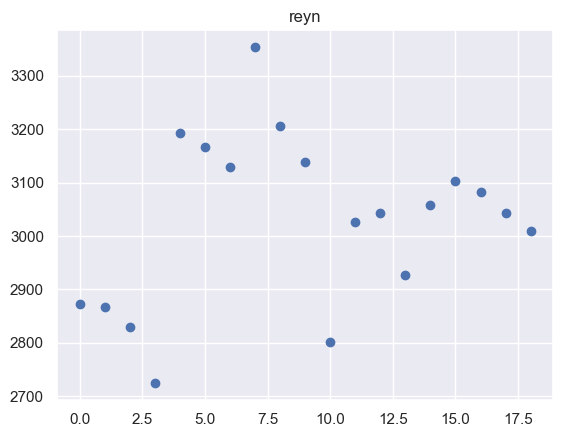

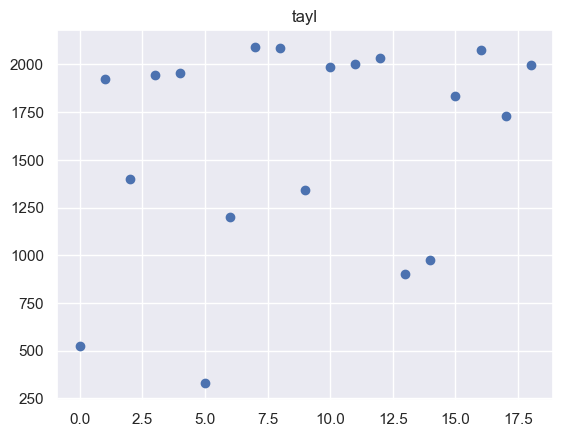

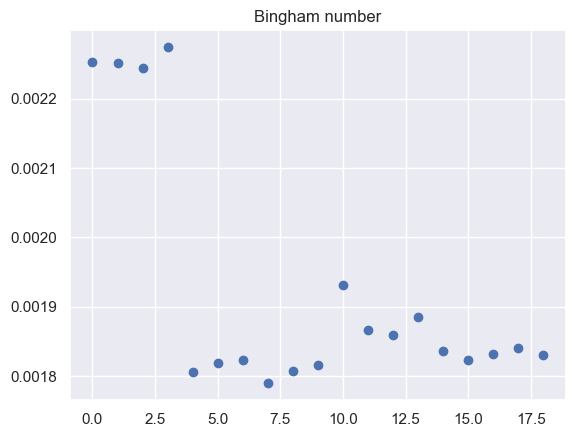

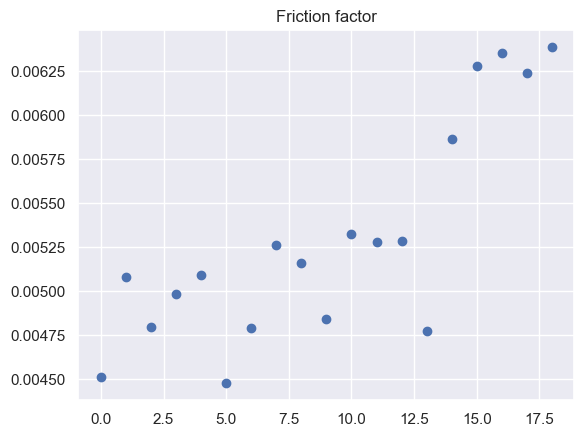

In [56]:
x = np.arange(0,len(df_of_variables_at_points),1)
for key,value in df_of_variables_at_points.items():
    plt.title(f'{key}')
    plt.scatter(x,value.values)
    plt.show()
    

In [57]:
df_of_variables_at_points.to_pickle(FILE_PATH_TEST_SET_CASE_102)